In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pickle
import datetime
from utils.es_utils import *
from utils.env_utils import *
from utils.train_utils import *
from models.Buffer import Buffer
from models.PredatorPolicy import PredatorPolicy
from models.PreyPolicy import PreyPolicy
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from models.Buffer import Pool
from utils.env_utils import *
from utils.eval_utils import *
from utils.train_utils import pretrain_policy_with_validation

In [2]:
# Create training folder
path = rf"..\data\2. Training\training\BC"
timestamp = datetime.datetime.now().strftime("%d.%m.%Y_%H.%M")
folder_name = f"BC Training - {timestamp} - Video Data"
save_dir = os.path.join(path, folder_name)
os.makedirs(save_dir, exist_ok=True)

# Expert Data
traj_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\yolo_detected'
couzin_path = rf'..\data\1. Data Processing\processed\couzin'
hl_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\hand_labeled'
ftw_path = rf'..\data\1. Data Processing\processed\video\3. full_track_windows'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pred_policy = PredatorPolicy().to(device)
pred_policy.set_parameters(init=True)

prey_policy = PreyPolicy(gain=0.0).to(device)
prey_policy.set_parameters(init=True)

expert_buffer = Buffer(pred_max_length=23000, prey_max_length=200000, device="cpu")

start_frame_pool = Pool(max_length=12100, device="cpu")
start_frame_pool.generate_startframes(ftw_path)
print(f"Start frames in pool: {len(start_frame_pool)}")

Start frames in pool: 11978


In [4]:
# Load Expert Data from local storage
print("Expert Buffer is empty, load data...")
expert_buffer.add_expert(traj_path)
#expert_buffer.clear(p=80)               # Reduce ratio of non-attack data by 90%. now ~equal
expert_buffer.add_expert(hl_path)       # hand-labeled data | Pred: 1057 | Prey: 33824
expert_buffer.add_expert(hl_path)
expert_buffer.add_expert(hl_path)

len_exp_pred, len_exp_prey = expert_buffer.lengths()
print("Storage of Predator Expert Buffer: ", len_exp_pred)
print("Storage of Prey Expert Buffer: ", len_exp_prey, "\n")

Expert Buffer is empty, load data...
Storage of Predator Expert Buffer:  23000
Storage of Prey Expert Buffer:  200000 



[PREDATOR] Epoch 01 | Train Loss: 0.550436 | Val Loss: 0.299159
[PREDATOR] Epoch 02 | Train Loss: 0.375572 | Val Loss: 0.191509
[PREDATOR] Epoch 03 | Train Loss: 0.364596 | Val Loss: 0.331111
[PREDATOR] Epoch 04 | Train Loss: 0.389393 | Val Loss: 0.530094
[PREDATOR] Epoch 05 | Train Loss: 0.465657 | Val Loss: 0.520212
[PREDATOR] Epoch 06 | Train Loss: 0.459621 | Val Loss: 0.323866
[PREDATOR] Epoch 07 | Train Loss: 0.393598 | Val Loss: 0.468775
[PREDATOR] Epoch 08 | Train Loss: 0.467222 | Val Loss: 0.439865
[PREDATOR] Epoch 09 | Train Loss: 0.453592 | Val Loss: 0.337091
[PREDATOR] Epoch 10 | Train Loss: 0.427002 | Val Loss: 0.430552
[PREDATOR] Epoch 11 | Train Loss: 0.404899 | Val Loss: 0.377193
[PREDATOR] Epoch 12 | Train Loss: 0.395665 | Val Loss: 0.397456
[PREDATOR] Epoch 13 | Train Loss: 0.483960 | Val Loss: 0.396697
[PREDATOR] Epoch 14 | Train Loss: 0.457015 | Val Loss: 0.341574
[PREDATOR] Epoch 15 | Train Loss: 0.433504 | Val Loss: 0.413131
[PREDATOR] Epoch 16 | Train Loss: 0.3854

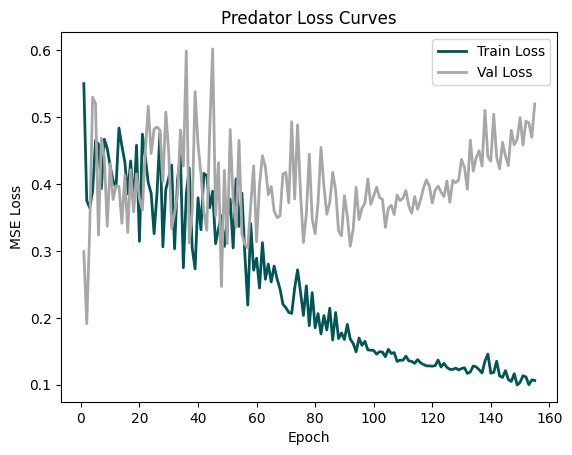

In [5]:
pred_policy, pred_logs = pretrain_policy_with_validation(pred_policy, prey_policy, expert_buffer, role='predator', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=500, lr=1e-3, early_stopping=True, patience=100, device=device)
torch.save(pred_policy, os.path.join(save_dir, "bc_pred_policy.pt"))

with open(os.path.join(save_dir, "bc_pred_logs.pkl"), "wb") as f:
    pickle.dump(pred_logs, f)

[PREY] Epoch 01 | Train Loss: 0.541378 | Val Loss: 0.527591 | Pred Gain: 0.031180527061223984
[PREY] Epoch 02 | Train Loss: 0.511647 | Val Loss: 0.466095 | Pred Gain: 0.031167352572083473
[PREY] Epoch 03 | Train Loss: 0.490250 | Val Loss: 0.464190 | Pred Gain: 0.031235624104738235
[PREY] Epoch 04 | Train Loss: 0.463466 | Val Loss: 0.455614 | Pred Gain: 0.03125133737921715
[PREY] Epoch 05 | Train Loss: 0.459536 | Val Loss: 0.427752 | Pred Gain: 0.03126395493745804
[PREY] Epoch 06 | Train Loss: 0.456777 | Val Loss: 0.446469 | Pred Gain: 0.031302355229854584
[PREY] Epoch 07 | Train Loss: 0.441778 | Val Loss: 0.465960 | Pred Gain: 0.03117888793349266
[PREY] Epoch 08 | Train Loss: 0.433206 | Val Loss: 0.487279 | Pred Gain: 0.03124857321381569
[PREY] Epoch 09 | Train Loss: 0.464220 | Val Loss: 0.476047 | Pred Gain: 0.03118622861802578
[PREY] Epoch 10 | Train Loss: 0.464710 | Val Loss: 0.462207 | Pred Gain: 0.031293995678424835
[PREY] Epoch 11 | Train Loss: 0.430944 | Val Loss: 0.417694 | Pre

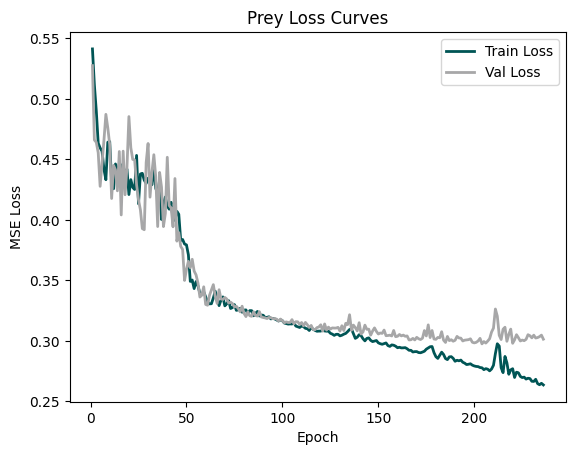

In [6]:
prey_policy, prey_logs = pretrain_policy_with_validation(prey_policy, pred_policy, expert_buffer, role='prey', val_ratio=0.2, pred_bs=64, prey_bs=2048, epochs=1000, lr=1e-3, early_stopping=True, patience=100, device=device)
torch.save(prey_policy, os.path.join(save_dir, "bc_prey_policy.pt"))

with open(os.path.join(save_dir, "bc_prey_logs.pkl"), "wb") as f:
    pickle.dump(prey_logs, f)

In [8]:
env = parallel_env(use_walls=True)
positions = start_frame_pool.sample(n=1)
env.reset(options=positions)
metrics = run_policies(env, pred_policy, prey_policy)

Press 'q' to end simulation.
